In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()
    
# https://dacon.io/forum/401657    
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output    

def smape_model():
    def smape(true, pred):
        v = 2 * abs(pred - true) / (abs(pred) + abs(true))
        output = np.mean(v) * 100
        return output    

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [7]:
# outlier 제거 
train = train.drop(train[train['num_date_time'].isin(['56_20220608 16'
                                                  ,'34_20220808 21'
                                                  ,'10_20220607 06','10_20220607 06'
                                                  ,'31_20220808 13','31_20220809 13', '31_20220808 14','31_20220808 13'
                                                  , '8_20220806 05', '8_20220707 08', '8_20220628 09'
                                                  ,'13_20220606 16','13_20220724 06','13_20220606 17','13_20220607 07'
                                                  ,'58_20220804 16'
                                                  ,'65_20220807 18'
                                                  ,'68_20220706 20','68_20220706 19'
                                                  ,'71_20220604 10','71_20220810 15','71_20220810 16'
                                                  , '73_20220707 12', '73_20220707 14', '73_20220707 11','73_20220707 13', '73_20220707 15', '73_20220808 13','73_20220803 14', '73_20220808 12', '73_20220803 15','73_20220808 11'
                                                 ])].index)

In [8]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'month', 'day', 'time',
       'weekday'],
      dtype='object')

In [9]:
col = ['건물유형','weekday', 'time']
target_encoding = train.groupby(col).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = col + ['min', 'mean','max']
train = train.merge(target_encoding, on=col, how='left')
test = test.merge(target_encoding, on=col, how='left')

In [10]:
train['강수량(mm)'].fillna(0, inplace=True)
train['풍속(m/s)'].fillna(train['풍속(m/s)'].mean(), inplace=True)
train['습도(%)'].fillna(train['습도(%)'].mean(), inplace=True)

test['강수량(mm)'].fillna(0, inplace=True)
test['풍속(m/s)'].fillna(test['풍속(m/s)'].mean(), inplace=True)
test['습도(%)'].fillna(test['습도(%)'].mean(), inplace=True)

In [11]:
############## 체감온도, https://www.weather.go.kr/plus/life/li_asset/HELP/basic/help_01_07.jsp
train['체감온도'] = 13.12 + 0.6215*train['기온(C)'] - 11.37*(train['풍속(m/s)']*3.6)**0.16 + 0.3965*(train['풍속(m/s)']*3.6)**0.16*train['기온(C)']
test['체감온도'] = 13.12 + 0.6215*test['기온(C)'] - 11.37*(test['풍속(m/s)']*3.6)**0.16 + 0.3965*(test['풍속(m/s)']*3.6)**0.16*test['기온(C)']

In [12]:
train.drop( train[(train['건물번호'].isin([1,16])) & (train['month'] == 6)].index, inplace=True)

In [13]:
no_work_day = train.groupby(['건물번호', '건물유형','month', 'day']).agg({'전력소비량(kWh)':['mean','max']}).reset_index()
no_work_day.columns = ['건물번호', '건물유형','month', 'day', 'khw_mean', 'khw_max']
total_mean = no_work_day[no_work_day['건물유형'].isin(['백화점및아울렛','할인마트'])].groupby(['건물번호']).khw_mean.mean().reset_index().rename(columns={'khw_mean':'b_mean'})

no_work_day = no_work_day.merge(total_mean, on='건물번호')
no_work_day.loc[no_work_day.b_mean > no_work_day.khw_max, '백화점휴무일'] = 1

train = train.merge(no_work_day[['건물번호', '건물유형','month', 'day', '백화점휴무일']], on=['건물번호', '건물유형','month', 'day'], how='left')
train['백화점휴무일'] = train['백화점휴무일'].fillna(0).astype(int)
test['백화점휴무일'] = 0

In [14]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
       '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'month', 'day', 'time',
       'weekday', 'min', 'mean', 'max', '체감온도', '백화점휴무일'],
      dtype='object')

In [15]:
from feature_engine.creation import CyclicalFeatures
cf = CyclicalFeatures()
col = ['time', '기온(C)']
train = pd.concat([train, cf.fit_transform(train[col]).drop(col, axis=1)], axis=1)
test = pd.concat([test, cf.fit_transform(test[col]).drop(col, axis=1)], axis=1)
train.shape, test.shape

((202530, 29), (16800, 26))

In [16]:
from sklearn.preprocessing import SplineTransformer
spline = SplineTransformer(degree=2, n_knots=3)
col = ['풍속(m/s)','냉방면적(m2)']
train = pd.concat([train, pd.DataFrame(spline.fit_transform(train[col]))], axis=1)
test = pd.concat([test, pd.DataFrame(spline.fit_transform(test[col]))], axis=1)

train.shape, test.shape

((202530, 37), (16800, 34))

In [17]:
days = [18, 19, 20, 21, 22, 23, 24]

X_train = train[~((train['month'] == 8) & (train['day'].isin(days)))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_train = train[~((train['month'] == 8) & (train['day'].isin(days)))]['전력소비량(kWh)']

X_test = train[(train['month'] == 8) & (train['day'].isin(days))].drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
y_test = train[(train['month'] == 8) & (train['day'].isin(days))]['전력소비량(kWh)']


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(185730, 32) (16800, 32) (185730,) (16800,)


In [18]:
#결측값을 0으로 채웁니다
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

## Regression Model Fit

,건물유형,유형별_score
0,건물기타,8.047312


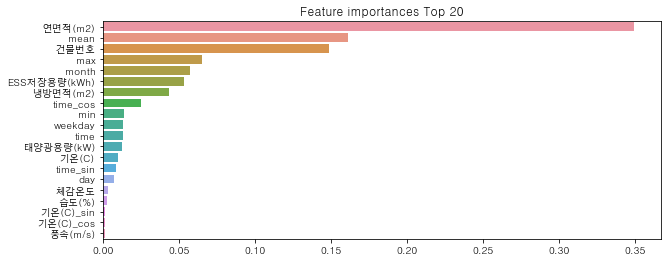

,건물유형,유형별_score
0,공공,6.182116


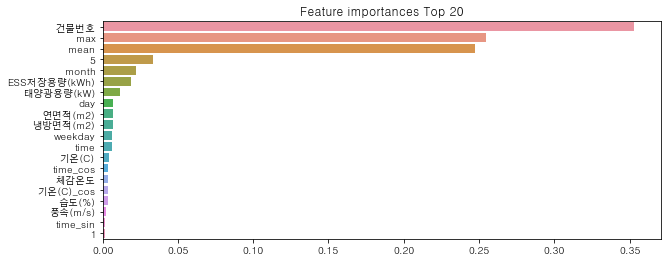

,건물유형,유형별_score
0,대학교,4.233396


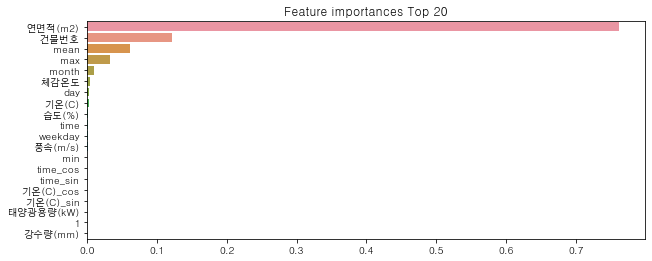

,건물유형,유형별_score
0,데이터센터,0.571398


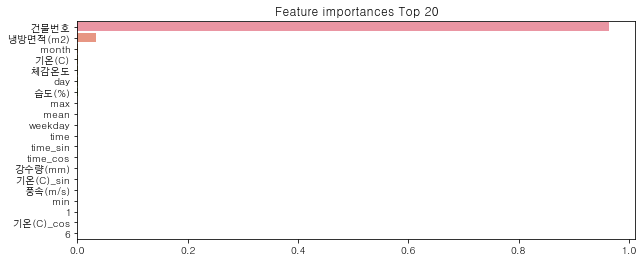

,건물유형,유형별_score
0,백화점및아울렛,5.814056


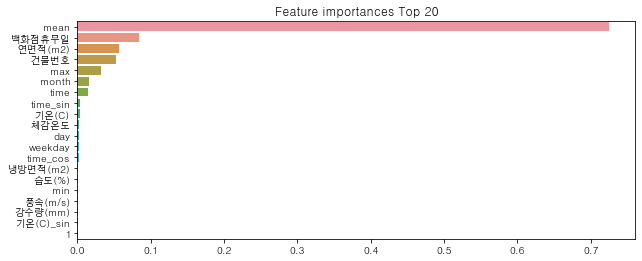

,건물유형,유형별_score
0,병원,4.156995


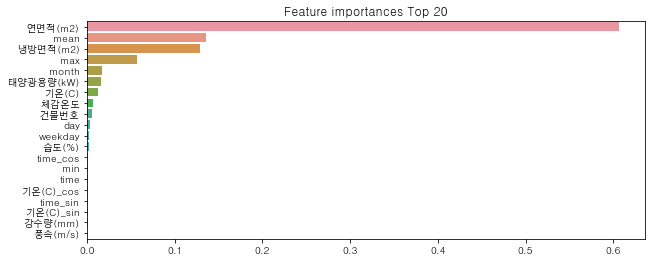

,건물유형,유형별_score
0,상용,7.983744


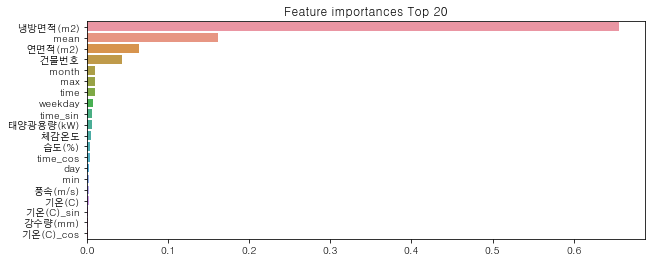

,건물유형,유형별_score
0,아파트,7.00357


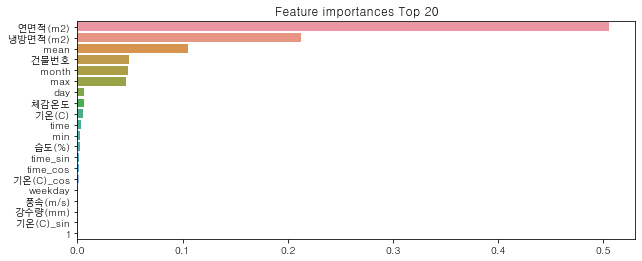

,건물유형,유형별_score
0,연구소,5.38679


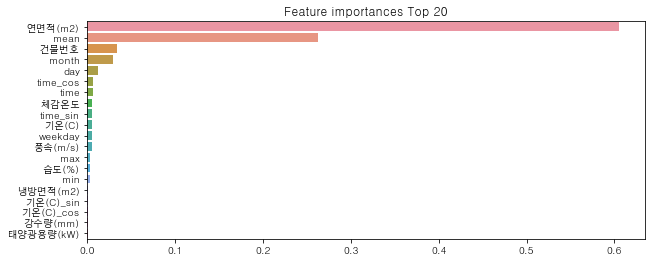

,건물유형,유형별_score
0,지식산업센터,5.714035


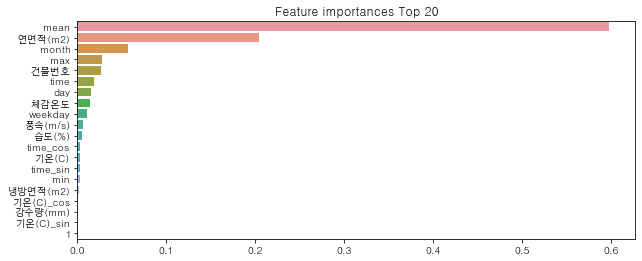

,건물유형,유형별_score
0,할인마트,6.843786


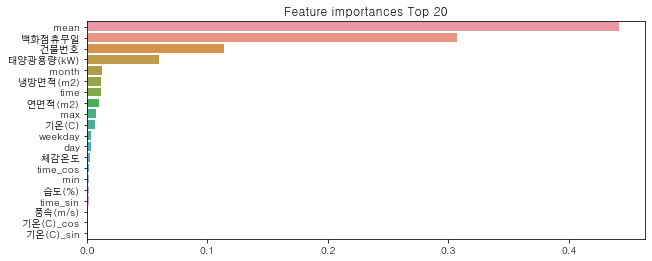

,건물유형,유형별_score
0,호텔및리조트,8.273882


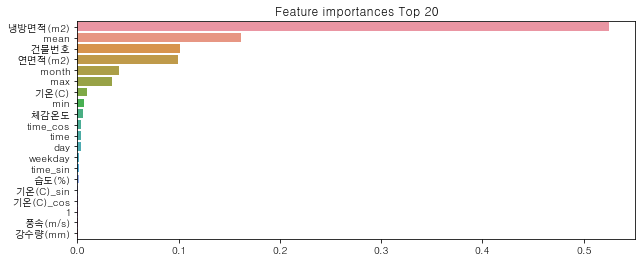

Wall time: 20.5 s


In [19]:
%%time 
metrics_type = pd.DataFrame()
for i in train['건물유형'].unique():
    temp_X_train = X_train[X_train['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물유형'] == i].drop(['건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물유형', '유형별_score']
    metrics_type = metrics_type.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    

,건물번호,건물별_score
0,1.0,6.064661


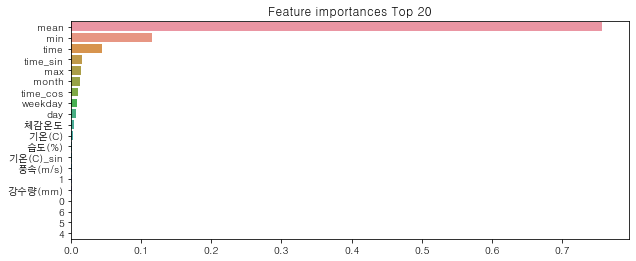

,건물번호,건물별_score
0,2.0,9.732527


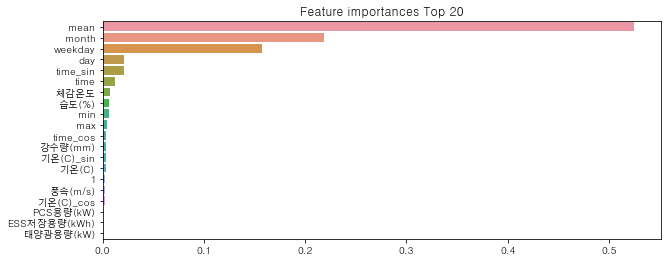

,건물번호,건물별_score
0,3.0,9.997935


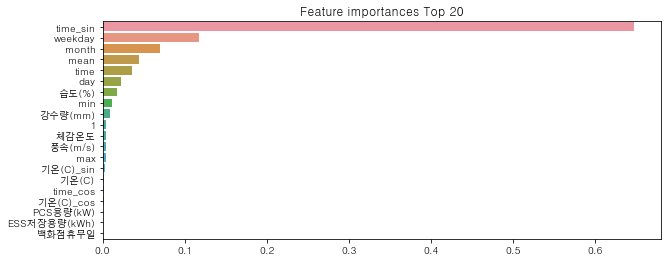

,건물번호,건물별_score
0,4.0,5.001545


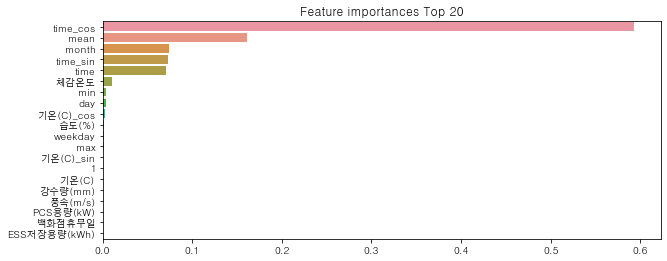

,건물번호,건물별_score
0,5.0,6.266214


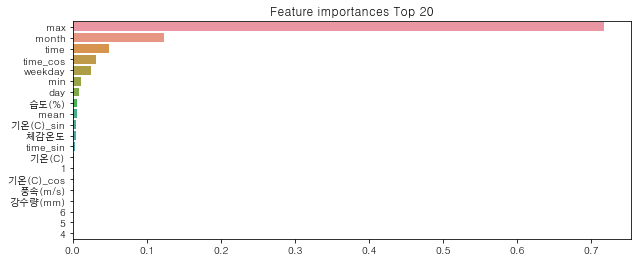

,건물번호,건물별_score
0,6.0,4.384813


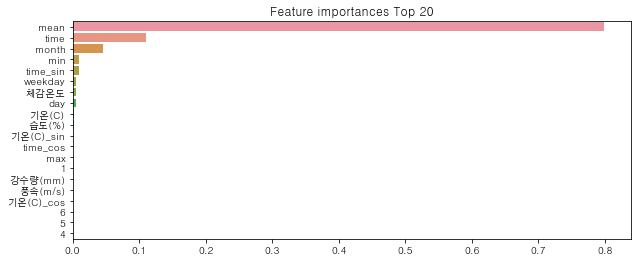

,건물번호,건물별_score
0,7.0,7.889845


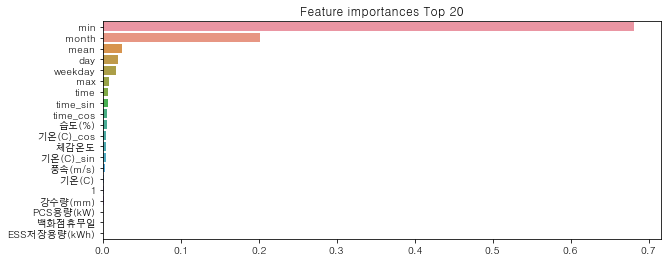

,건물번호,건물별_score
0,8.0,5.952187


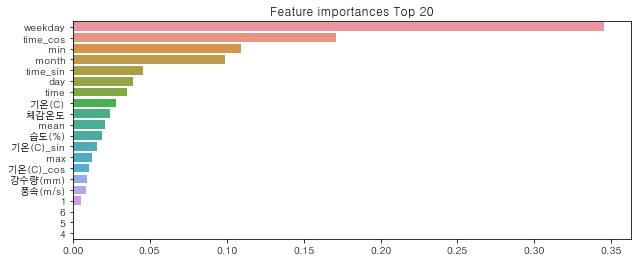

,건물번호,건물별_score
0,9.0,4.149462


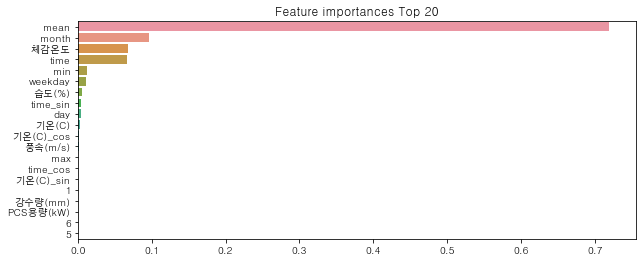

,건물번호,건물별_score
0,10.0,10.28173


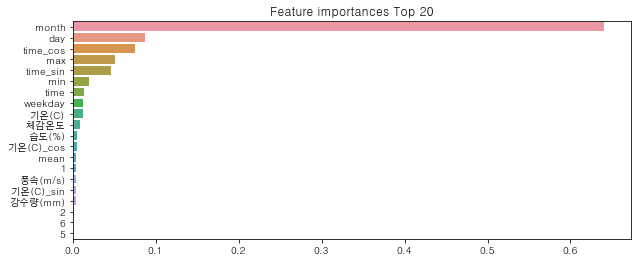

,건물번호,건물별_score
0,11.0,4.086222


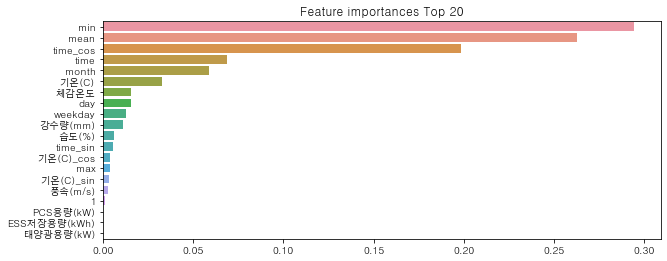

,건물번호,건물별_score
0,12.0,4.494315


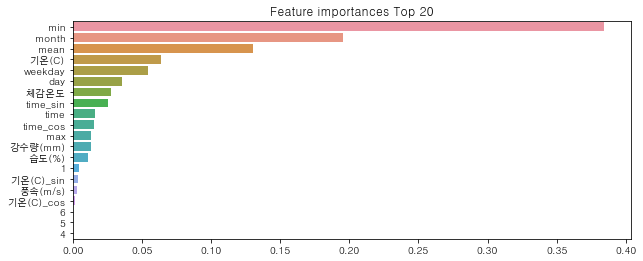

,건물번호,건물별_score
0,13.0,9.431005


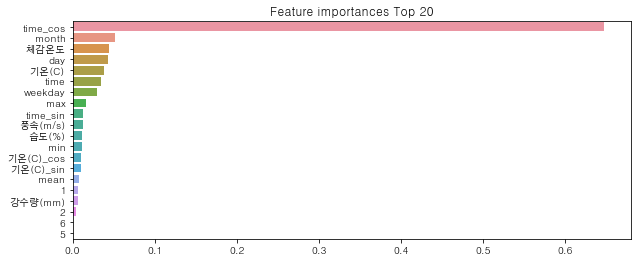

,건물번호,건물별_score
0,14.0,20.530404


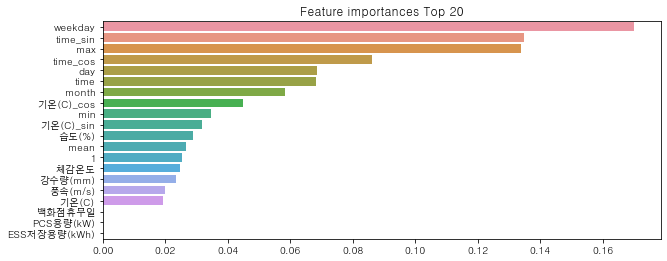

,건물번호,건물별_score
0,15.0,3.790286


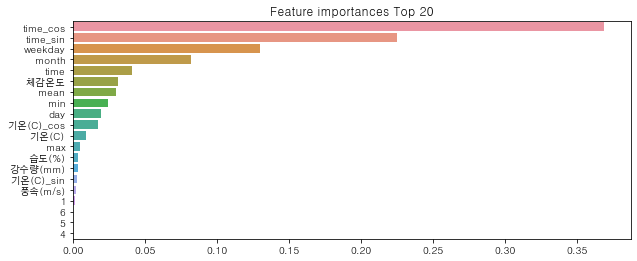

,건물번호,건물별_score
0,16.0,4.596095


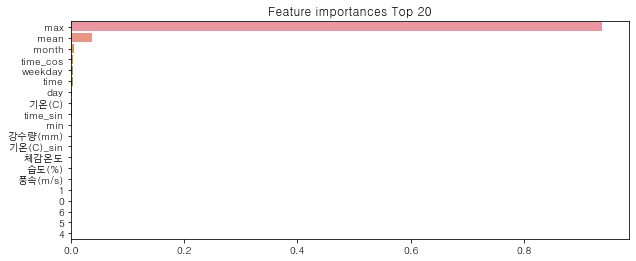

,건물번호,건물별_score
0,17.0,7.360978


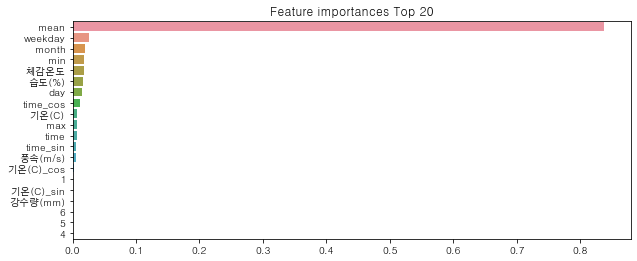

,건물번호,건물별_score
0,18.0,7.185873


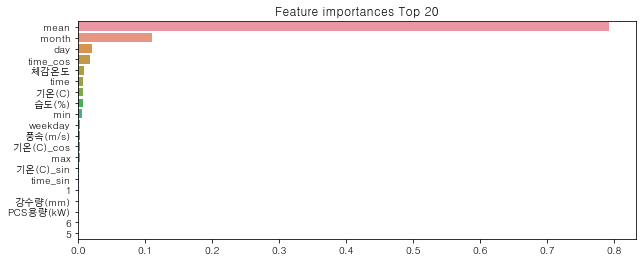

,건물번호,건물별_score
0,19.0,8.143294


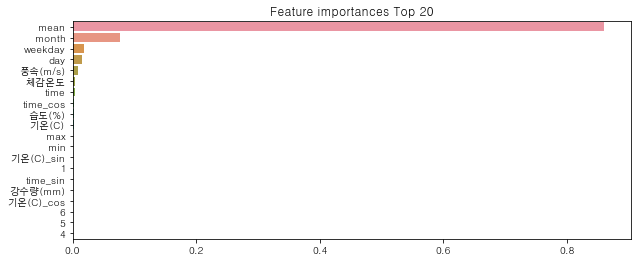

,건물번호,건물별_score
0,20.0,6.535523


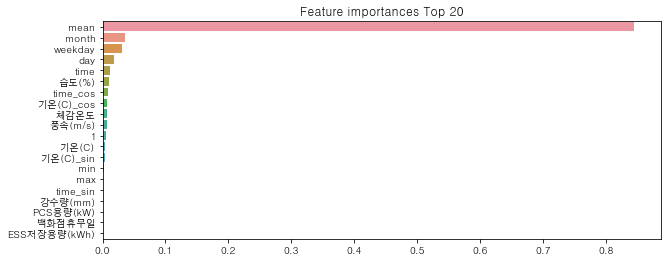

,건물번호,건물별_score
0,21.0,6.599759


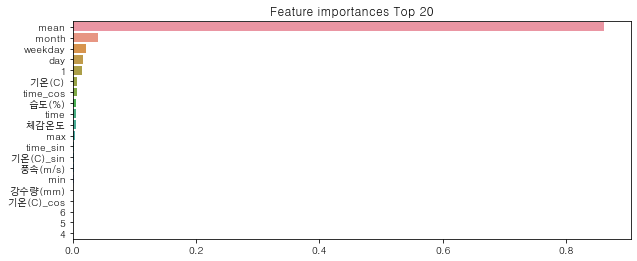

,건물번호,건물별_score
0,22.0,5.510874


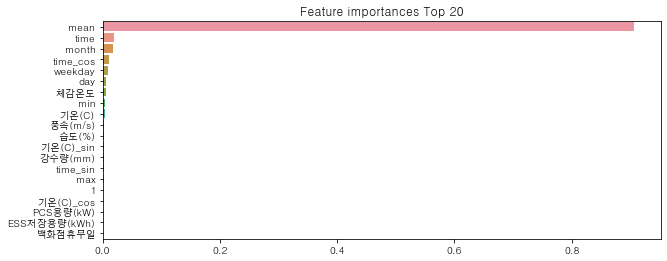

,건물번호,건물별_score
0,23.0,2.385473


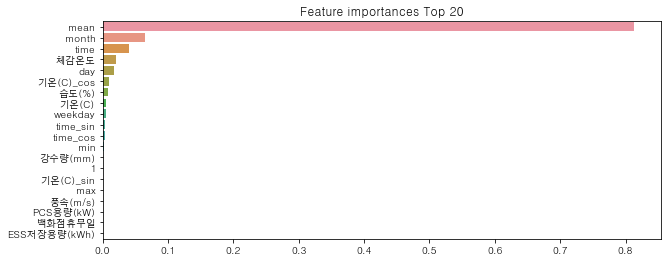

,건물번호,건물별_score
0,24.0,2.811814


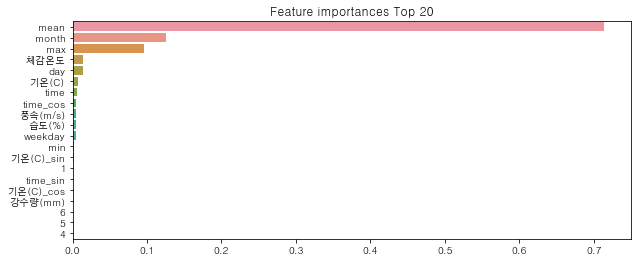

,건물번호,건물별_score
0,25.0,2.456761


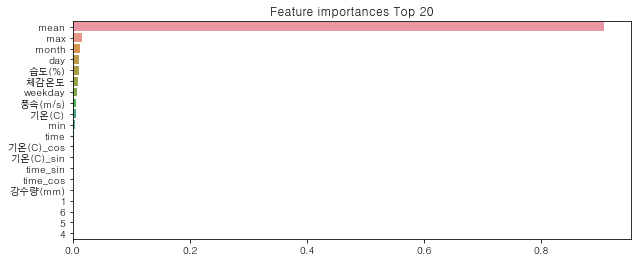

,건물번호,건물별_score
0,26.0,3.605262


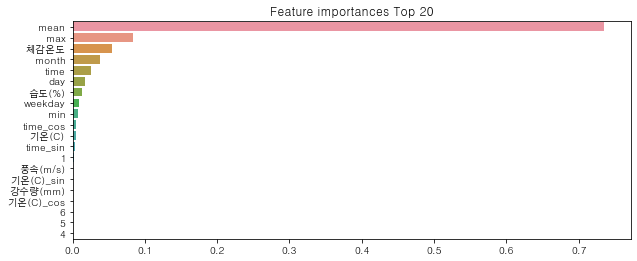

,건물번호,건물별_score
0,27.0,2.015632


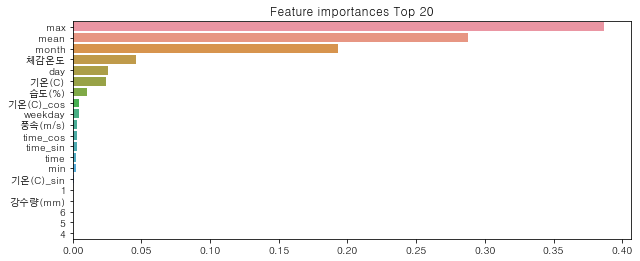

,건물번호,건물별_score
0,28.0,5.94311


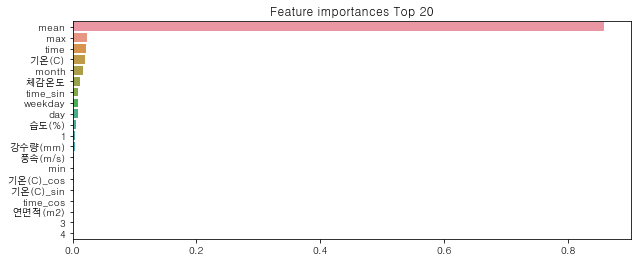

,건물번호,건물별_score
0,29.0,4.752557


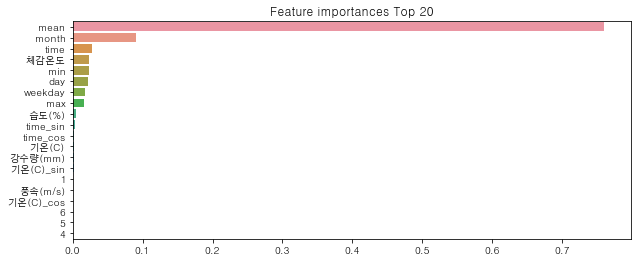

,건물번호,건물별_score
0,30.0,9.051432


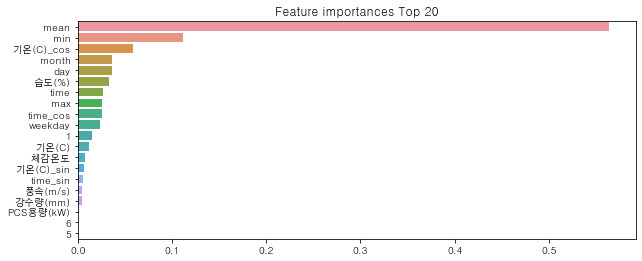

,건물번호,건물별_score
0,31.0,4.937258


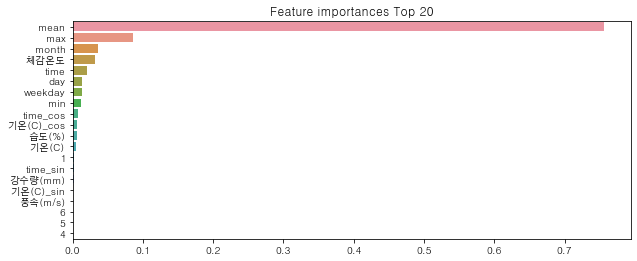

,건물번호,건물별_score
0,32.0,0.44908


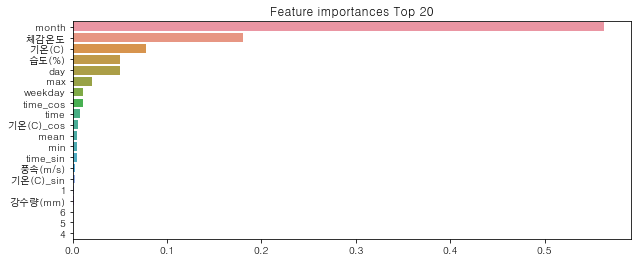

,건물번호,건물별_score
0,33.0,0.354816


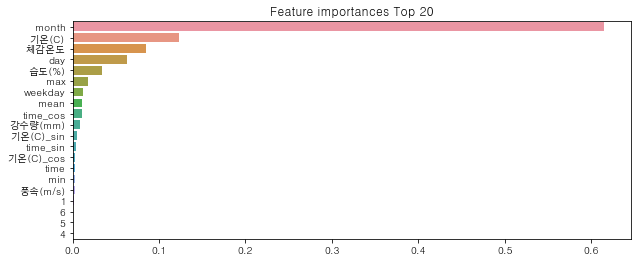

,건물번호,건물별_score
0,34.0,0.819031


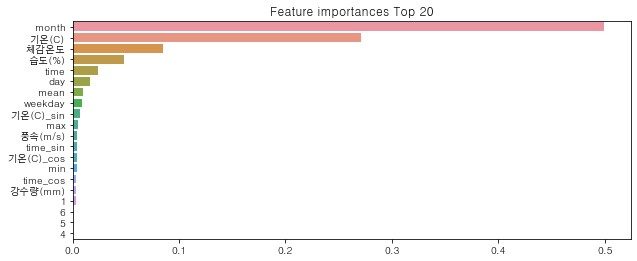

,건물번호,건물별_score
0,35.0,0.504489


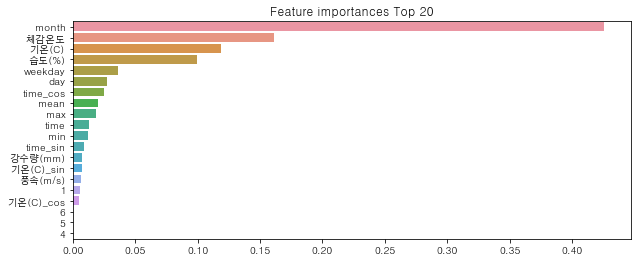

,건물번호,건물별_score
0,36.0,0.559633


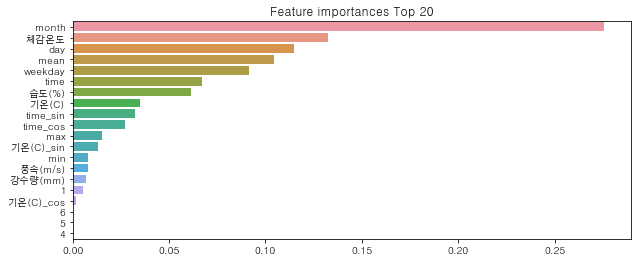

,건물번호,건물별_score
0,37.0,3.650365


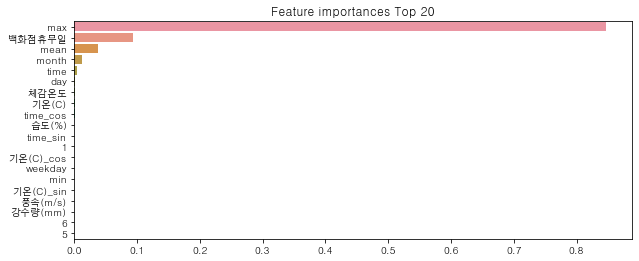

,건물번호,건물별_score
0,38.0,3.803213


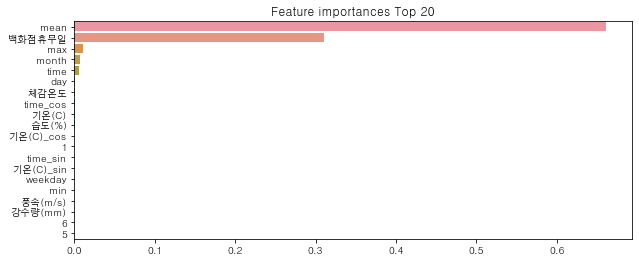

,건물번호,건물별_score
0,39.0,4.051328


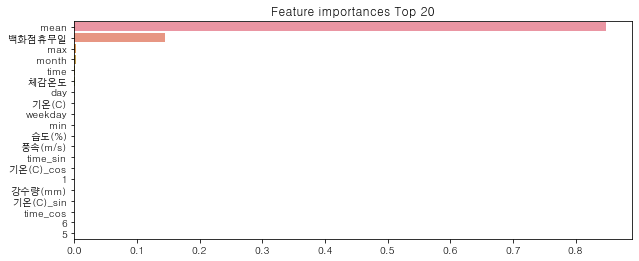

,건물번호,건물별_score
0,40.0,8.770539


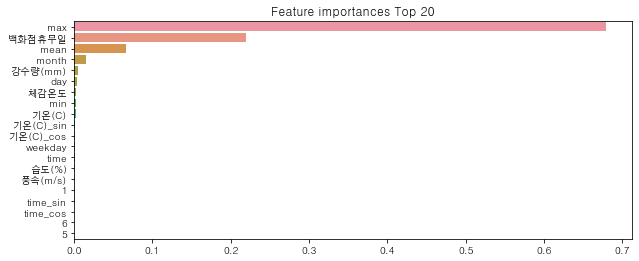

,건물번호,건물별_score
0,41.0,4.679456


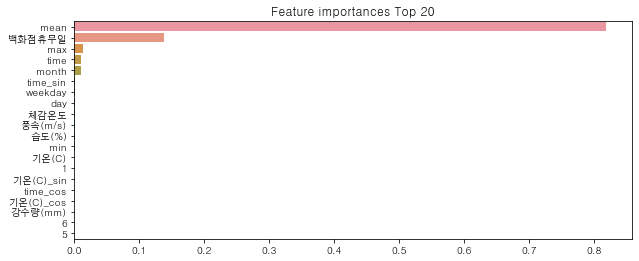

,건물번호,건물별_score
0,42.0,4.744121


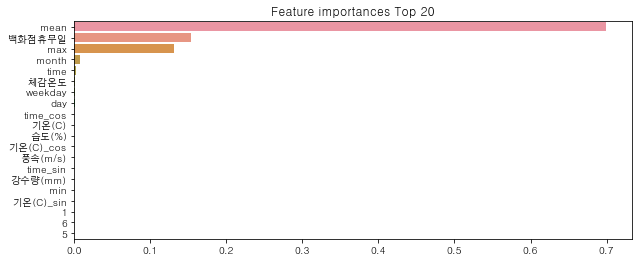

,건물번호,건물별_score
0,43.0,6.015824


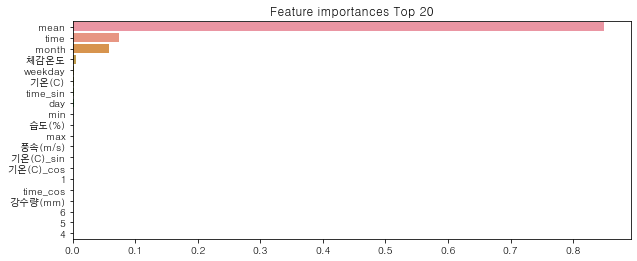

,건물번호,건물별_score
0,44.0,4.12636


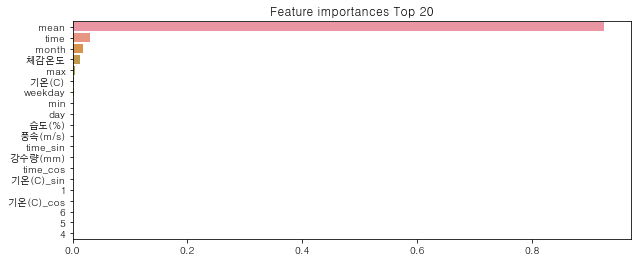

,건물번호,건물별_score
0,45.0,2.246959


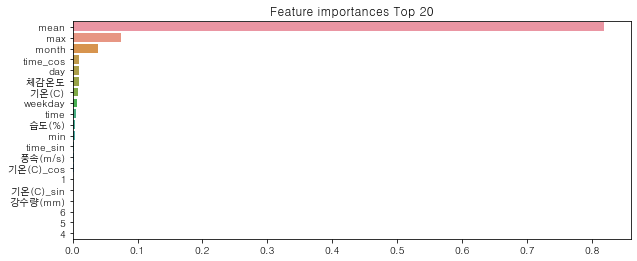

,건물번호,건물별_score
0,46.0,6.416203


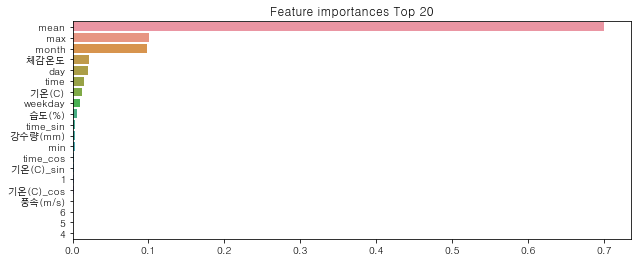

,건물번호,건물별_score
0,47.0,4.808664


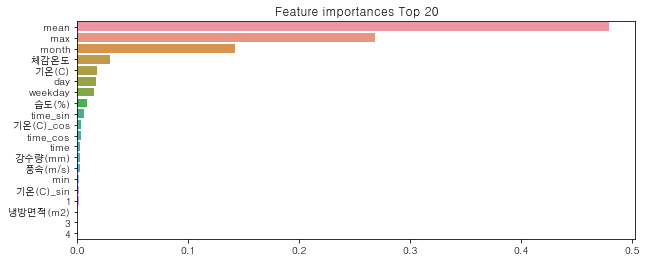

,건물번호,건물별_score
0,48.0,2.512584


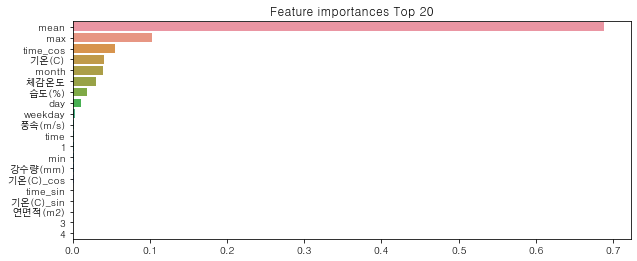

,건물번호,건물별_score
0,49.0,3.737677


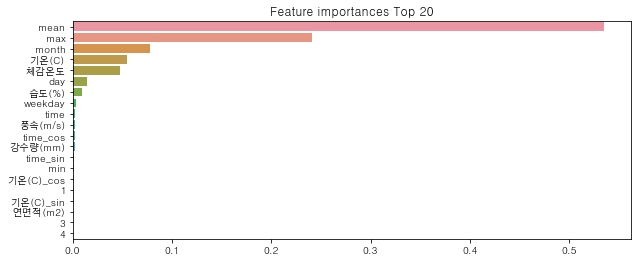

,건물번호,건물별_score
0,50.0,2.945247


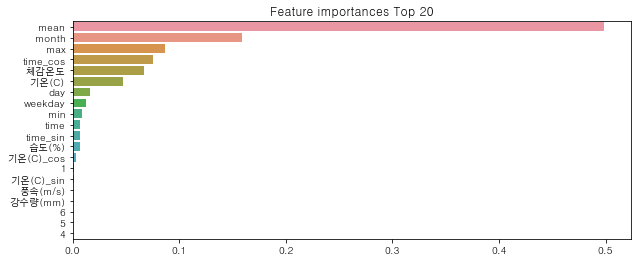

,건물번호,건물별_score
0,51.0,5.194594


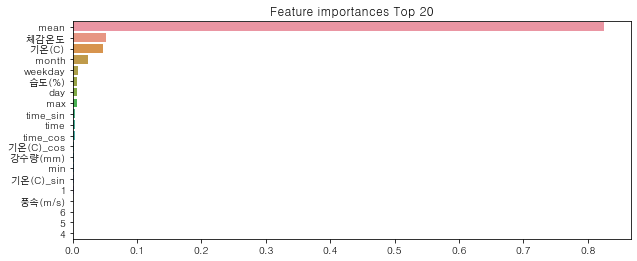

,건물번호,건물별_score
0,52.0,4.047547


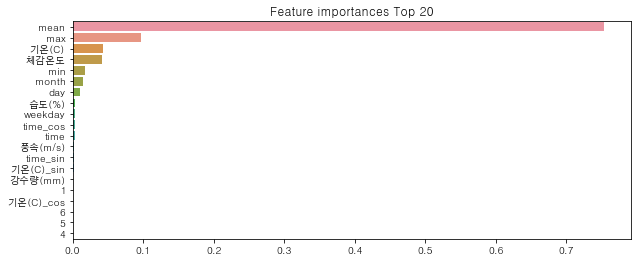

,건물번호,건물별_score
0,53.0,13.43764


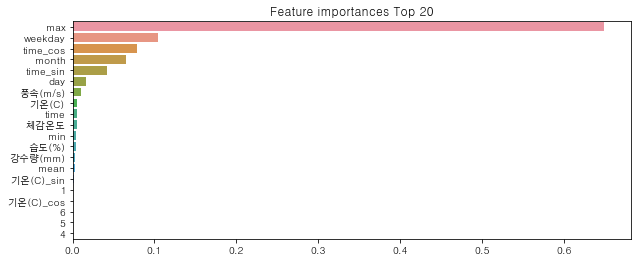

,건물번호,건물별_score
0,54.0,23.528065


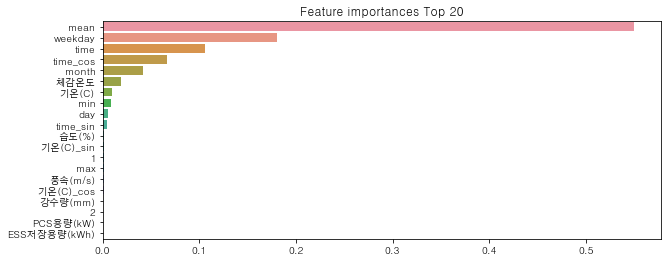

,건물번호,건물별_score
0,55.0,1.765094


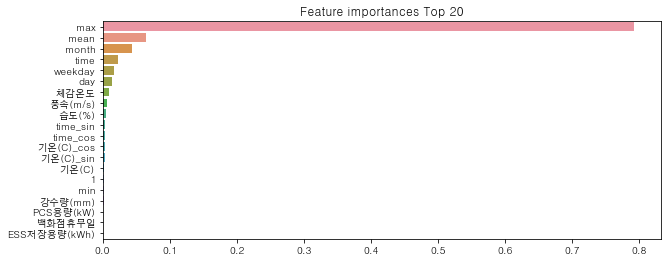

,건물번호,건물별_score
0,56.0,0.96285


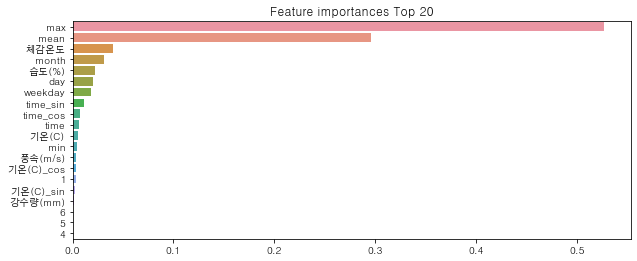

,건물번호,건물별_score
0,57.0,5.23681


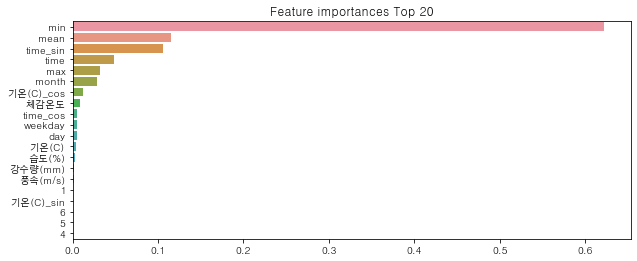

,건물번호,건물별_score
0,58.0,0.640909


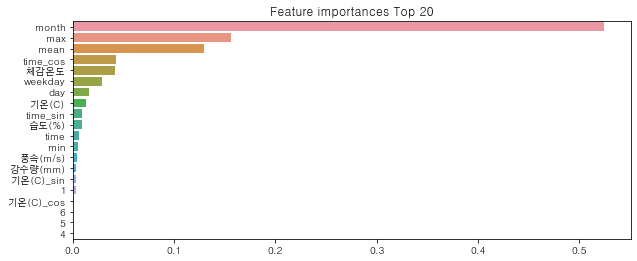

,건물번호,건물별_score
0,59.0,5.974014


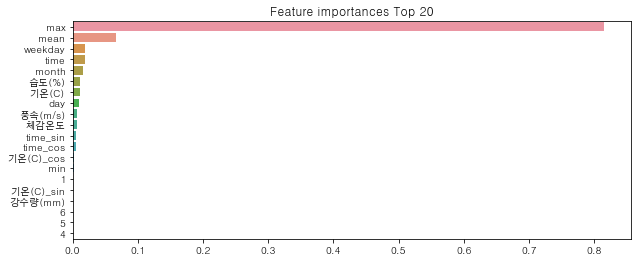

,건물번호,건물별_score
0,60.0,6.069348


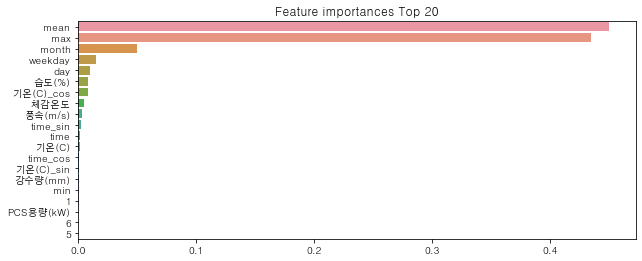

,건물번호,건물별_score
0,61.0,4.780546


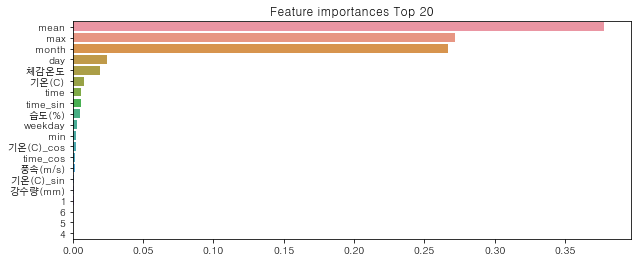

,건물번호,건물별_score
0,62.0,5.19171


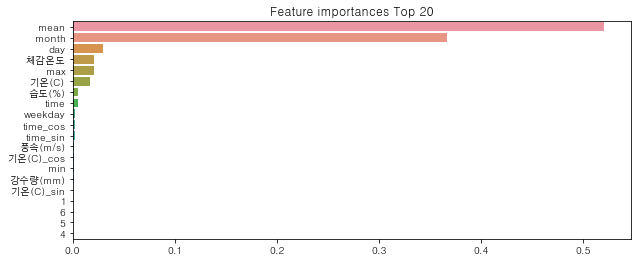

,건물번호,건물별_score
0,63.0,6.657222


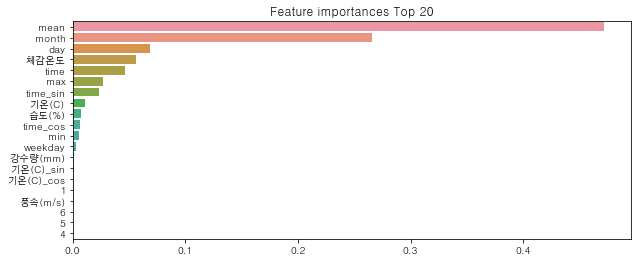

,건물번호,건물별_score
0,64.0,5.467523


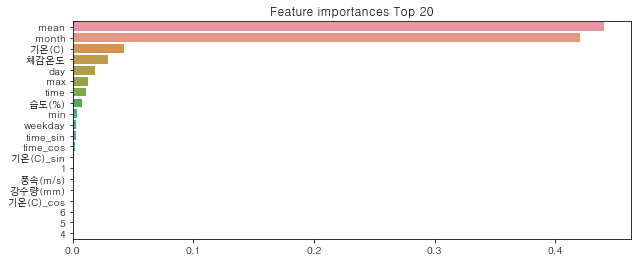

,건물번호,건물별_score
0,65.0,9.310831


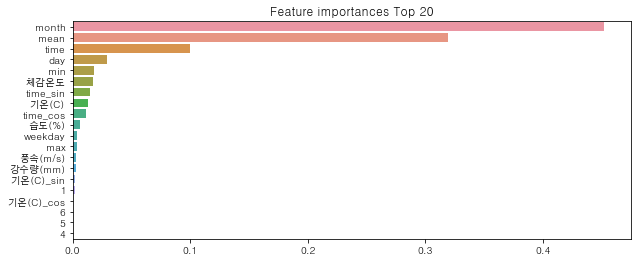

,건물번호,건물별_score
0,66.0,5.656418


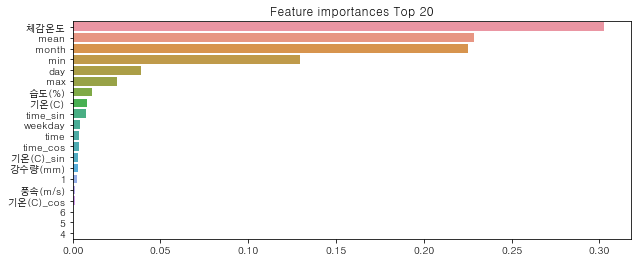

,건물번호,건물별_score
0,67.0,9.753762


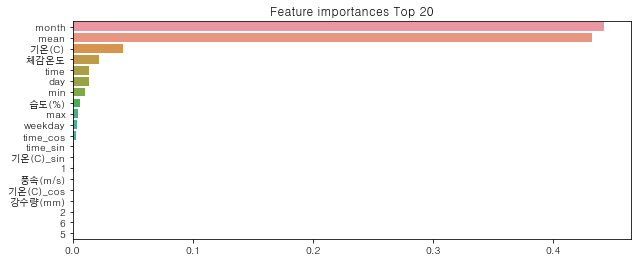

,건물번호,건물별_score
0,68.0,4.523041


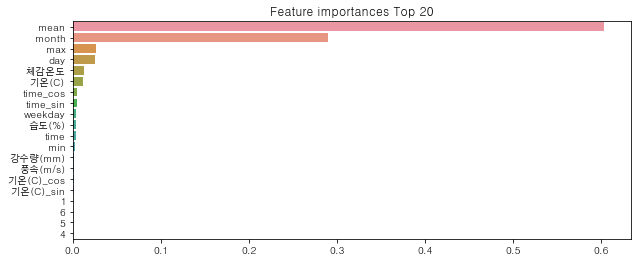

,건물번호,건물별_score
0,69.0,3.066071


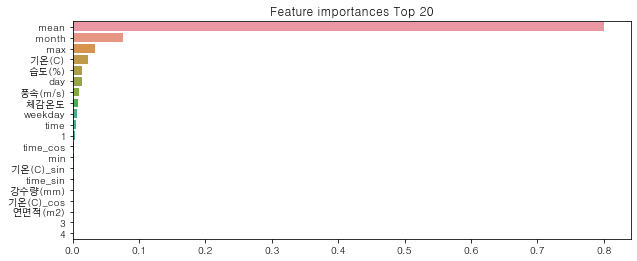

,건물번호,건물별_score
0,70.0,3.274161


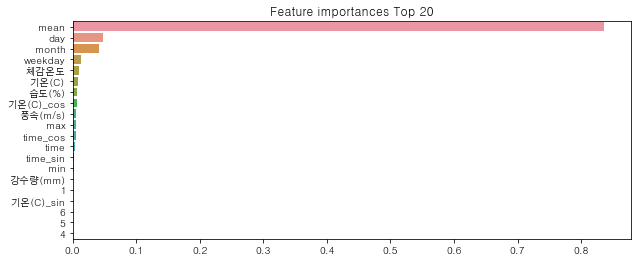

,건물번호,건물별_score
0,71.0,6.475878


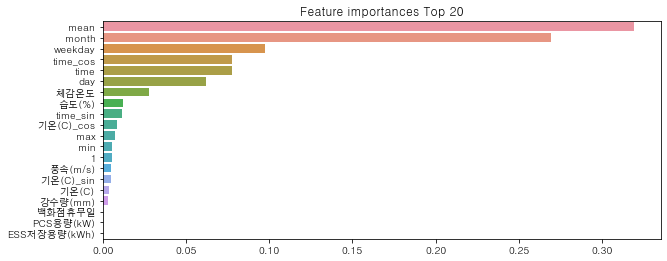

,건물번호,건물별_score
0,72.0,5.800817


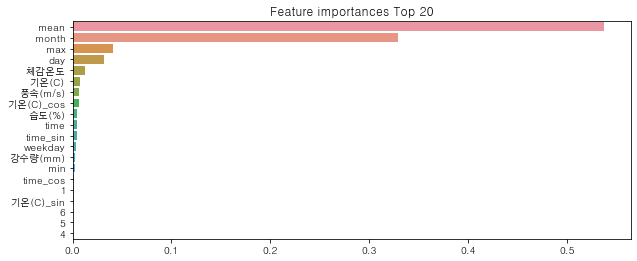

,건물번호,건물별_score
0,73.0,4.4195


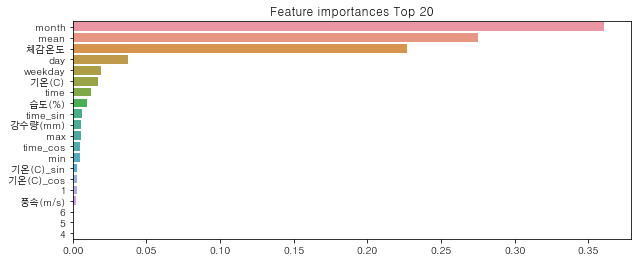

,건물번호,건물별_score
0,74.0,5.647579


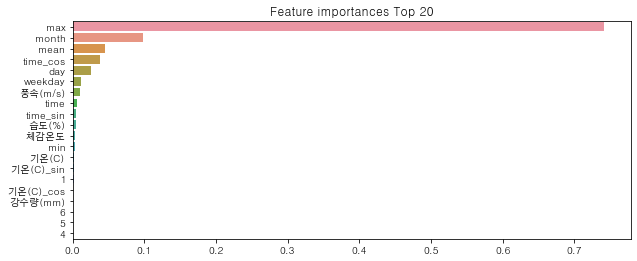

,건물번호,건물별_score
0,75.0,5.269909


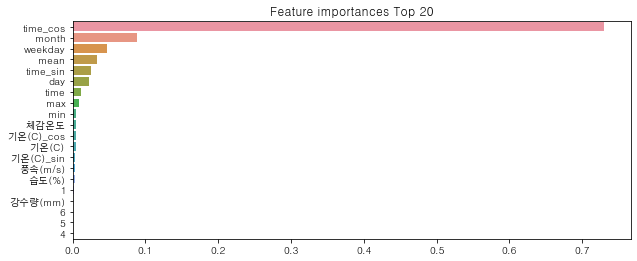

,건물번호,건물별_score
0,76.0,5.097231


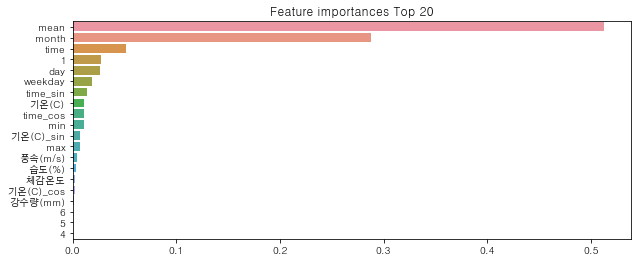

,건물번호,건물별_score
0,77.0,2.948184


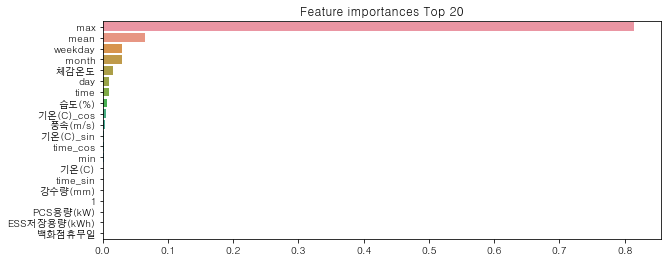

,건물번호,건물별_score
0,78.0,5.304642


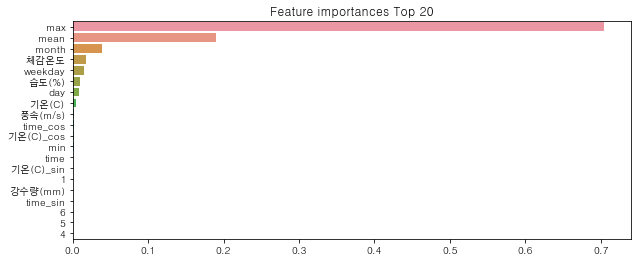

,건물번호,건물별_score
0,79.0,3.677432


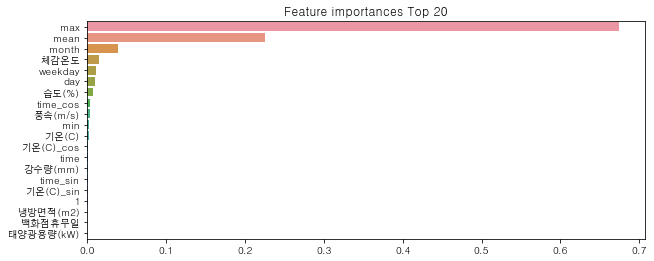

,건물번호,건물별_score
0,80.0,4.413684


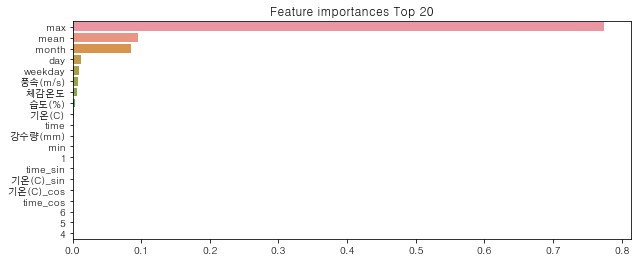

,건물번호,건물별_score
0,81.0,3.7089


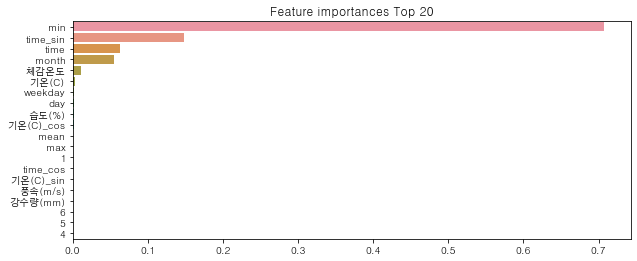

,건물번호,건물별_score
0,82.0,5.116265


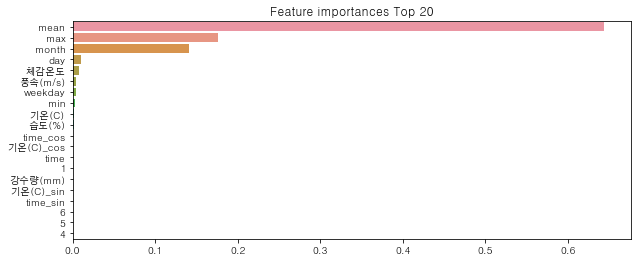

,건물번호,건물별_score
0,83.0,3.343839


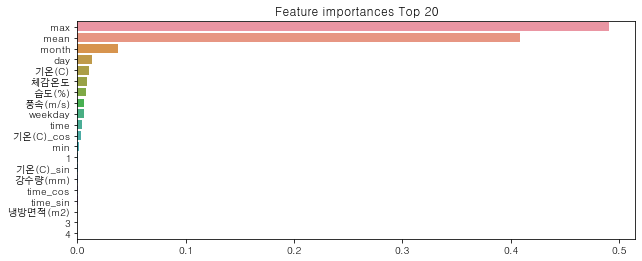

,건물번호,건물별_score
0,84.0,3.237567


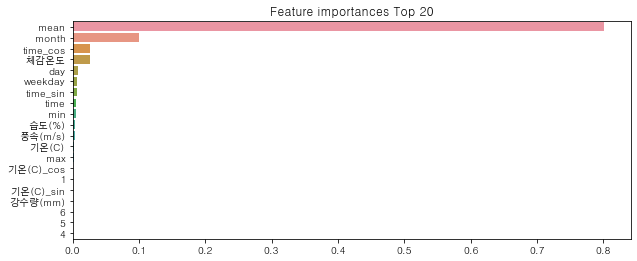

,건물번호,건물별_score
0,85.0,3.849111


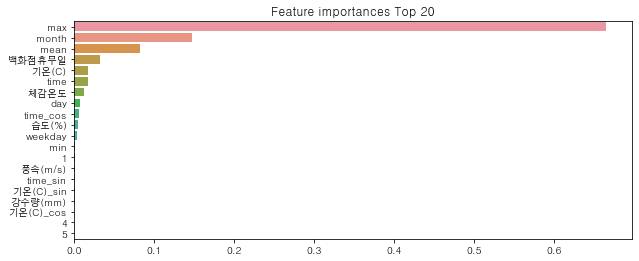

,건물번호,건물별_score
0,86.0,4.613257


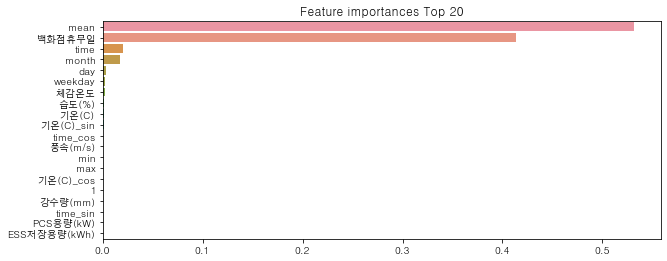

,건물번호,건물별_score
0,87.0,9.935702


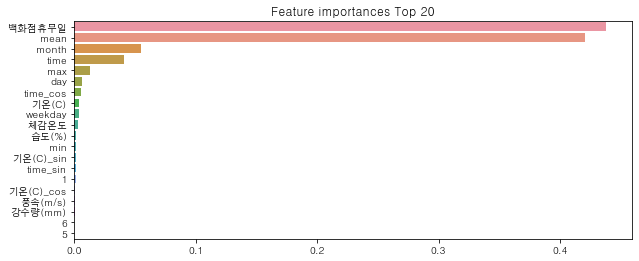

,건물번호,건물별_score
0,88.0,3.157122


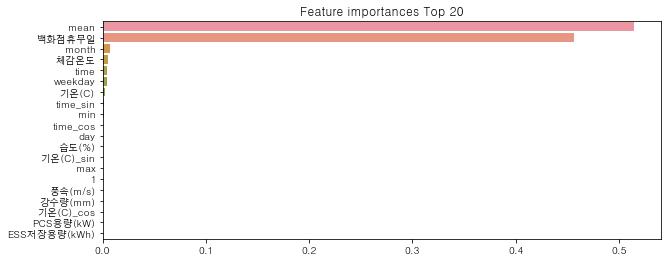

,건물번호,건물별_score
0,89.0,4.730596


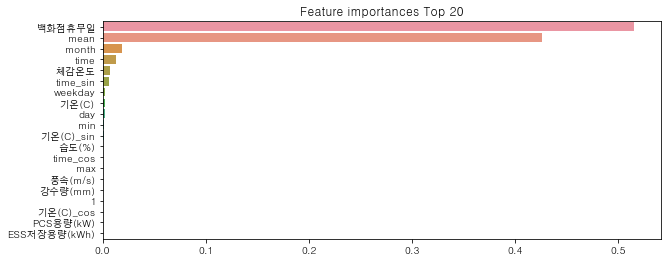

,건물번호,건물별_score
0,90.0,5.023079


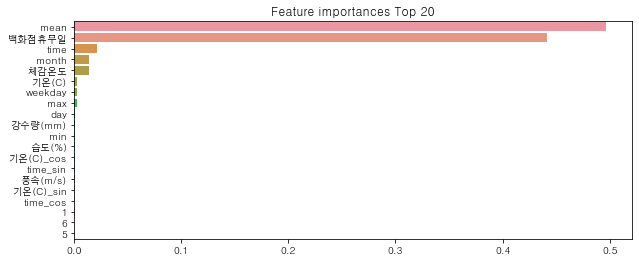

,건물번호,건물별_score
0,91.0,13.300148


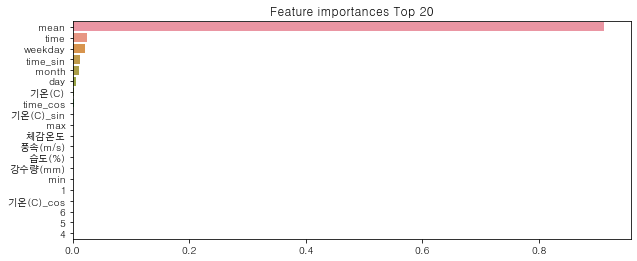

,건물번호,건물별_score
0,92.0,5.804924


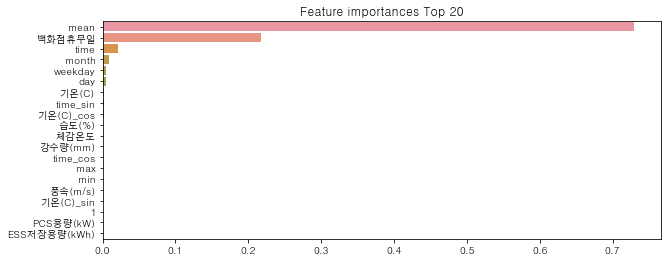

,건물번호,건물별_score
0,93.0,6.307953


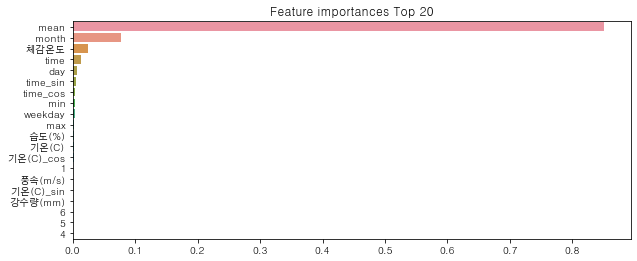

,건물번호,건물별_score
0,94.0,7.353532


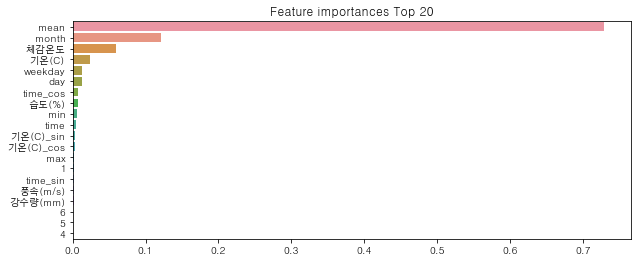

,건물번호,건물별_score
0,95.0,16.383531


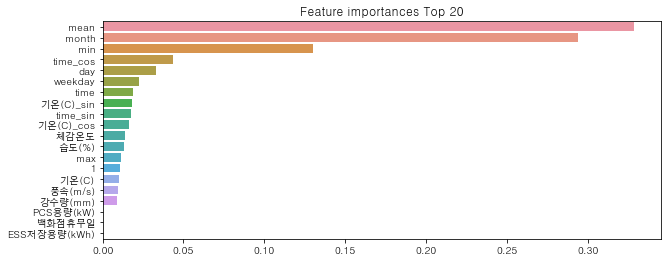

,건물번호,건물별_score
0,96.0,3.40108


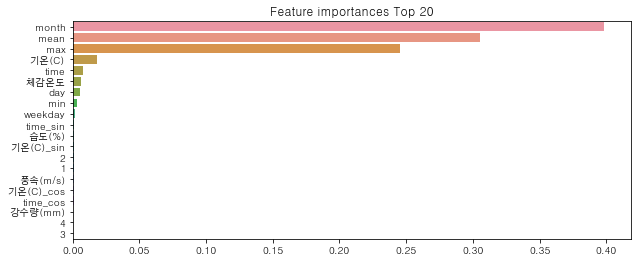

,건물번호,건물별_score
0,97.0,5.25711


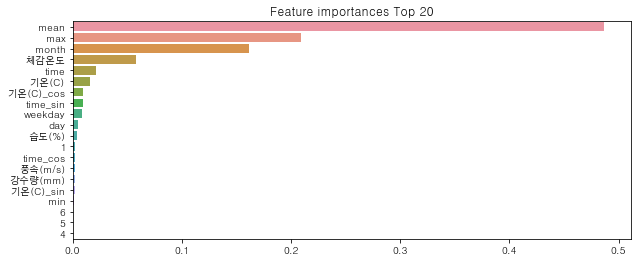

,건물번호,건물별_score
0,98.0,14.112037


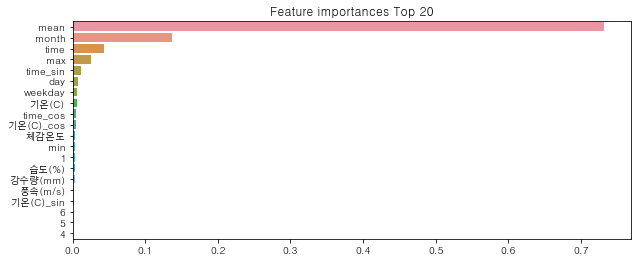

,건물번호,건물별_score
0,99.0,3.646727


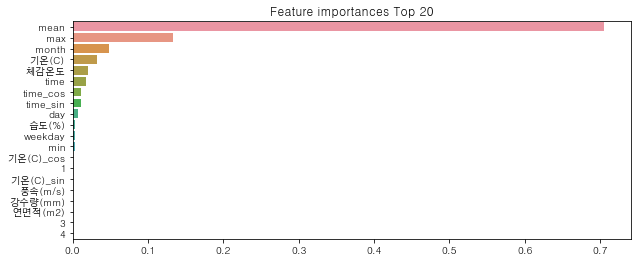

,건물번호,건물별_score
0,100.0,5.378691


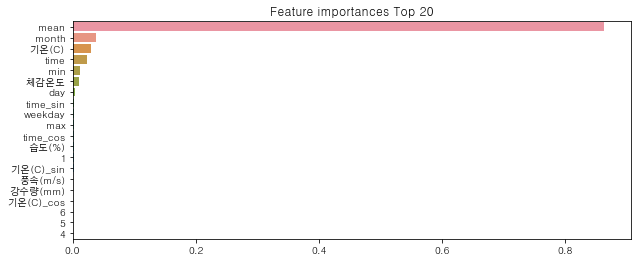


Wall time: 59.6 s


In [20]:
%%time 
metrics_bno = pd.DataFrame()
for i in train['건물번호'].unique():

    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
        
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, smape(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', '건물별_score']
    metrics_bno = metrics_bno.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [21]:
metrics_bno['건물번호'] = metrics_bno['건물번호'].astype(int)

In [22]:
metrics_bno = metrics_bno.merge(building_info[['건물유형','건물번호']], on=['건물번호'])

In [23]:
metrics = metrics_bno.merge(metrics_type, on=['건물유형'])
metrics[:2]

,건물번호,건물별_score,건물유형,유형별_score
0,1,6.064661,건물기타,8.047312
1,2,9.732527,건물기타,8.047312


In [24]:
# 유형보다 건물이 더 좋은 스코어를 가지는 건물번호 list
bno = metrics[metrics['건물별_score'] < metrics['유형별_score']]['건물번호'].values
len(bno), bno

(69,
 array([  1,   4,   5,   6,   7,   8,   9,  11,  12,  15,  16,  22,  23,
         24,  25,  26,  27,  32,  33,  35,  36,  37,  38,  39,  41,  42,
         44,  45,  48,  49,  50,  52,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  66,  68,  69,  70,  73,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  88,  89,  90,  92,  93,  94,
         96,  97,  99, 100]))

In [25]:
metrics_type['유형별_score'].mean(), metrics_bno['건물별_score'].mean()
# (7.026821963284757, 6.107093822048833)

(5.850923337494376, 5.623946180584398)

In [26]:
# 가중 평균 
metrics_type['유형별_score'].mean() * ((100-len(bno))/100) + metrics_bno['건물별_score'].mean() * (len(bno)/100)

5.694309099226491

In [27]:
# 5.782455883802
# 5.508758307811814

In [28]:
metrics['score'] = metrics['유형별_score'] 
metrics.loc[metrics['건물번호'].isin(bno), 'score'] = metrics['건물별_score']

In [29]:
metrics['건물이낫다'] = metrics['건물별_score'] < metrics['유형별_score']

In [30]:
# metrics.to_excel('오차큰것부터_20230810-3.xlsx')

## Inference & Submit

In [34]:
%%time
result_type = pd.DataFrame()
for i in train['건물유형'].unique():
    
    temp_X_train = train[train['건물유형'] == i].drop(['건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물유형'] == i].drop(['건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_type = result_type.append( pd.concat([test[test['건물유형'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_유형별']).reset_index()], axis=1) )
    
result_type.shape    

Wall time: 15.2 s


(16800, 37)

In [35]:
%%time
result_bno = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = XGBRegressor(random_state=42)
    model.set_params(**{'objective':smape_model()})
    
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result_bno = result_bno.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer_건물별']).reset_index()], axis=1) )
    
result_bno.shape    

Wall time: 25.9 s


(16800, 37)

In [36]:
result = result_type[['num_date_time','건물번호','answer_유형별','weekday', 'time']].merge(result_bno[['num_date_time','건물번호','answer_건물별']], on=['num_date_time','건물번호'])
result['answer'] = result['answer_유형별'] 
result.loc[result['건물번호'].isin(bno), 'answer'] = result['answer_건물별']

# 후처리 
postprocessing = train.groupby(['건물번호', 'weekday','time'])['전력소비량(kWh)'].min().reset_index()
result = result.merge(postprocessing, on=['건물번호', 'weekday','time'])
result.loc[result['answer'] < result['전력소비량(kWh)'], 'answer'] = result['전력소비량(kWh)']

result[['num_date_time','answer']].to_csv('20230811-3.csv', index=False)